데이터 전처리
===
(정규화, 로그 변환, 스케일러, 원-핫 인코딩)
---
* 선형회귀 모델을 위한 데이터 변환
    - 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형함수를 찾아내 결과를 예측함.
    - 또한 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포 형태인 경우를 매우 선호함.
### 로그 변환, 스케일러, 다항 특성 적용

<table>
 <tr>
    <th>변환대상</th>
    <th>설명</th>
  </tr>
  <tr>
    <td>타깃값 변환</td>
    <td>회귀에서 타깃값은 반드시 정규 분포를 가져야 함.</br>
    이를 위해 주로 로그변환을 적용.</td>
  </tr>
  <tr>
    <td rowspan="3">피처값 변환</td>
    <td>StandardScaler : 평균이 0, 분산이 1인 표준정규분포를 가진 데이터 세트로 변환</br>
    MinMaxScaler : 최솟값이 0, 최댓값이 1인 값으로 정규화를 수행
    </td>
  </tr>
  <tr>
    <td>스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환.</br>
    보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와 같은 방법을 적용.
    </td>  
  </tr>
  <tr>
    <td>원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨. 로그 변환은 매우 유용한 변환이며, 실제로 선형 회귀에서는 앞의 1, 2번 방법보다 로그 변환이 훨씬 많이 사용되는 변환 방법.</br>
    왜냐하면 1번 방법의 경우 예측 성능 향상을 크게 기대하기 어려운 경우가 많으며, 2번 방법의 경우 피처의 개수가 매우 많을 경우에는 다항 변환으로 생성되는 피처의 개수가 기하급수적으로 늘어나 과적합 이슈가 발생할 수 있기 때문.
    </td>
  </tr>
</table>

### 인코딩
* 선형 회귀의 데이터 인코딩은 일반적으로 레이블 인코딩이 아닌 원-핫 인코딩을 적용함.
* 레이블 인코딩 : 카테고리 별로 1, 2, 3, 4, ...
* 원-핫 인코딩 : 0과 1로 구성된 행렬 형태

#### 실습 : 피처 데이터 변환에 따른 예측 성능 비교

(506,)


(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

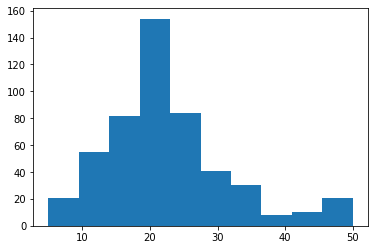

In [1]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

house_price = load_boston()
X_data = house_price.data
y_target = house_price.target

print(y_target.shape)
plt.hist(y_target, bins=10)

In [2]:
# method는 표준 정규 분포 변환(Standard), 최대값/최소값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않음.
def get_scaled_data(method="None", p_degree=None, input_data=None) :
    if method == "Standard" :
        scaled_data = StandardScaler().fit_transform(input_data)
        # 정규분포화
    elif method == "MinMax" :
        scaled_data = MinMaxScaler().fit_transform(input_data)
        # 최대최소
    elif method == "Log" :
        scaled_data = np.log1p(input_data)
        # 로그변환
    else :
        scaled_data = input_data
        # 메소드 입력 안 했을 경우 그대로 저장.

    if p_degree != None :
        scaled_data = PolynomialFeatures(
            degree=p_degree, include_bias=False).fit_transform(scaled_data)
        # p_degree 있는 경우 Polynomial 진행
    
    return scaled_data

In [3]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import pandas as pd

data = []

def get_linear_reg_eval(method="Ridge", params=[], X_data_n=None, y_target_n=None, verbose=True) :
    sub_data = []
    for param in params :        
        ridge = Ridge(alpha=param)
        neg_mse_scores = cross_val_score(ridge, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5, verbose=verbose)
        rmse_scores = np.sqrt(-1 * neg_mse_scores)
        avg_rmse = np.mean(rmse_scores)
        print(f"alpha {param}일 때 5 folds의 개별 평균 RMSE : {avg_rmse:.4f}")
        sub_data.append(np.round(avg_rmse,3))
    data.append(sub_data)
    

In [4]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods=[(None, None), ("Standard", None), ("Standard", 2),
                ("MinMax", None), ("MinMax", 2), ("Log", None)]

for scale_method in scale_methods :
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],
                                    input_data=X_data)
    print(f"\n## 변환 유형:{scale_method[0]}, Polynomial Degree:{scale_method[1]}")

    # alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고,
    # 회귀 계수값들을 DataFrame으로 반환해주는 함수
    get_linear_reg_eval("Ridge", params=alphas, X_data_n=X_data_scaled,
                        y_target_n=y_target, verbose=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 folds의 개별 평균 RMSE : 5.7885
alpha 1일 때 5 folds의 개별 평균 RMSE : 5.6526
alpha 10일 때 5 folds의 개별 평균 RMSE : 5.5182
alpha 100일 때 5 folds의 개별 평균 RMSE : 5.3296

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 folds의 개별 평균 RMSE : 5.8260
alpha 1일 때 5 folds의 개별 평균 RMSE : 5.8029
alpha 10일 때 5 folds의 개별 평균 RMSE : 5.6368
alpha 100일 때 5 folds의 개별 평균 RMSE : 5.4214

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 folds의 개별 평균 RMSE : 8.8272
alpha 1일 때 5 folds의 개별 평균 RMSE : 6.8713
alpha 10일 때 5 folds의 개별 평균 RMSE : 5.4849
alpha 100일 때 5 folds의 개별 평균 RMSE : 4.6344

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 folds의 개별 평균 RMSE : 5.7636
alpha 1일 때 5 folds의 개별 평균 RMSE : 5.4650
alpha 10일 때 5 folds의 개별 평균 RMSE : 5.7542
alpha 100일 때 5 folds의 개별 평균 RMSE : 7.6349

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 folds의 개별 평균 RMSE : 5.2976
alpha 1일 때 5 folds의 개별 평균 RMSE : 4.3227
alpha 10일 때 5 folds의 개별 평균 RMSE : 5.1852
alpha 100일 때 5 f

In [5]:
result_df = pd.DataFrame(data, columns=[["alpha값", "alpha값", "alpha값", "alpha값"], ["alpha=0.1", "alpha=1", "alpha=10", "alpha=100"]])
result_df["변환유형"] = ["원본데이터", "표준정규분포", "표준정규분포 + 2차 다항식", "최솟값/최댓값 정규화", "최솟값/최댓값 정규화 + 2차 다항식", "로그변환"]
result_df.set_index("변환유형", inplace=True)
result_df

alpha값                           
                     alpha=0.1 alpha=1 alpha=10 alpha=100
변환유형                                                     
원본데이터                    5.788   5.653    5.518     5.330
표준정규분포                   5.826   5.803    5.637     5.421
표준정규분포 + 2차 다항식          8.827   6.871    5.485     4.634
최솟값/최댓값 정규화              5.764   5.465    5.754     7.635
최솟값/최댓값 정규화 + 2차 다항식     5.298   4.323    5.185     6.538
로그변환                     4.770   4.676    4.836     6.241

## 로지스틱 회귀
### 로지스틱 회귀 개요
* 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘. 즉, 로지스틱 회귀는 분류에 사용됨.       
로지스틱 회귀가 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라, 시그모이드(Sigmoid)함수 최적선을 찾고, 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정함.
* 로지스틱 회귀는 주로 이진분류에 사용됨(다중 클래스 분류에도 적용 가능함).     
  로지스틱 회귀에서 예측 값은 예측 확률을 의미하며, 예측 확률이 0.5 이상이면 1로, 0.5 이하이면 0으로 예측함. 로지스틱 회귀의 예측 확률은 시그모이드 함수의 출력값으로 계산됨.   
<img src="C:/Users/user/Desktop/Vocational_Training/FinTech/images/functions_graph.png" width="40%">

#### 로지스틱 회귀 예측

* 시그모이드 함수 : $y = \frac{1}{1+e^{-x}}$
* 단순 선형회귀 : $y=w_1x + w_0$가 있다고 할 때,    
  로지스틱 회귀는 0과 1을 예측하기에 단순 회귀식은 의미가 없음.    
  하지만 Odds(성공확률/실패확률)을 통해 선형 회귀식에 확률을 적용할 수 있음.
  $$Odds(p) = \frac{p}{1-p}$$ 
  하지만 확률p의 범위가 (0,1)이므로 선형 회귀의 반환값인 $(-\infty, +\infty)$에 대응하기 위해 로그 변환을 수행하고 이 값에 대해 선형 회귀를 적용함.    
  $$\log{Odds(p)} = w_1x + w_0$$
  해당 식을 데이터 값 x의 확률 p로 정리하면 아래와 같음
  $$p(x)=\frac{1}{1+e^{-(w_1x+w_0)}}$$
  로지스틱 회귀는 학습을 통해 시그모이드 함수의 w를 최적화하여 예측하는 것.

#### 시그모이드를 이용한 로지스틱 회귀 예측

<img src="C:/Users/user/Desktop/Vocational_Training/FinTech/images/Sigmoid.png" width="40%">

* 로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어남. 이 때문에 로지스틱 회귀를 이진 분류의 기본 모델로 사용하는 경우가 많음. 또한 로지스틱 회귀는 희소한 데이터 세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에서도 자주 사용됨.
* 사이킷런은 LogisticRegression 클래스로 로지스틱 회귀를 구현함. 주요 하이퍼 파라미터로 penalty와 C가 있음. Penalty는 Regularization의 유형을 설정함. 'l2'로 설정시 L2 규제 등. default는 'l2'. C는 규제 강도를 조절하는 alpha값의 역수. C값이 작을수록 규제 강도가 큼.   
$$C=\frac{1}{\alpha}$$


  #### 실습 : 로지스틱 회귀

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# 위스콘신 유방암 데이터 불러오기
cancer = load_breast_cancer()

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(
    data_scaled, cancer.target, test_size=0.3, random_state=0
)

In [8]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)

lr_preds = lr_clf.predict(X_test)

# accuracy와 roc_auc 측정
print(f"accuracy {accuracy_score(y_test, lr_preds):.3f}")
print(f"roc_auc {roc_auc_score(y_test, lr_preds):.3f}")

accuracy 0.977
roc_auc 0.972


In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    "penalty" : ["l2", "l1"],
    "C" :[0.01, 0.1, 1, 1, 5, 10]
}

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring="accuracy", cv=3)
grid_clf.fit(data_scaled, cancer.target)
print(f"최적 하이퍼 파라미터 : {grid_clf.best_params_}, 최적 평균 정확도 : {grid_clf.best_score_:.3f}")

최적 하이퍼 파라미터 : {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도 : 0.975


## 회귀 트리
### 회귀 트리 개요
* 회귀 트리 : 트리 기반의 회귀 방식
* 사이킷런의 결정 트리 및 결정 트리 기반의 앙상블 알고리즘 분류 뿐만 아니라 회귀도 가능.
* 트리가 CART(Classification And Regression Trees)를 기반으로 만들어졌기 때문.   
 CART는 분류 뿐만 아니라 회귀도 가능한 트리 분할 알고리즘.
* CART 회귀 트리는 분류와 유사하게 분할을 하며, 분할 기준은 RSS(SSE)가 최소가 될 수 있는 기준을 찾아 분할됨.
* 최종 분할이 완료된 후에 각 분할 영역에 있는 데이터 결정값들의 평균 값으로 학습/예측함.   
<img src="C:/Users/user/Desktop/Vocational_Training/FinTech/images/CART.png" width="40%">

### 회귀 트리의 오버피팅(과대적합)
* 회귀 트리 역시 복잡한 트리 구조를 가질 경우 오버피팅하기 쉬움. 트리의 크기와 노드 개수의 제한 등의 방법을 통해 오버 피팅을 개선 할 수 있음.   
<img src="C:/Users/user/Desktop/Vocational_Training/FinTech/images/CART_overfitting.png" width="40%">

#### 실습 : 회귀 트리로 보스턴 집값 예측

In [10]:
# 데이터 불러오기
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# 보스턴 데이터 세트 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# 랜덤 포레스트로 교차 검증
bostonDF["PRICE"] = boston.target
y_target = bostonDF["PRICE"]
X_data = bostonDF.drop(["PRICE"], axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(f"5 교차 검증의 개별 Negative MSE scores : {np.round(neg_mse_scores,2)}")
print(f"5 교차 검증의 개별 RMSE scores : {np.round(rmse_scores,2)}")
print(f"5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")

5 교차 검증의 개별 Negative MSE scores : [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores : [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [11]:
def get_model_cv_prediction(model=None, X_data=None, y_target=None) :
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    if model == dt_reg :
        print(f"### DecisionTreeRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")
    elif model == rf_reg :
        print(f"### RandomForestRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")
    else :
        print(f"### XGBRegressor ### \n5 교차 검증의 평균 RMSE : {np.round(avg_rmse,3)}")

In [12]:
# 3개 회귀 트리 모델로 회귀 수행

from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor


# max_depth=4짜리 디시전 트리
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
# n_estimators=1000짜리 랜덤 포레스트
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
# n_estimators=1000짜리 XGBoost
xg_reg = XGBRegressor(num_round=1000, verbosity=0)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, xg_reg]
for model in models :
    get_model_cv_prediction(model, X_data, y_target)

### DecisionTreeRegressor ### 
5 교차 검증의 평균 RMSE : 5.978
### RandomForestRegressor ### 
5 교차 검증의 평균 RMSE : 4.423
### XGBRegressor ### 
5 교차 검증의 평균 RMSE : 4.251


##### 회귀 트리의 피처 중요도 파악

<AxesSubplot:>

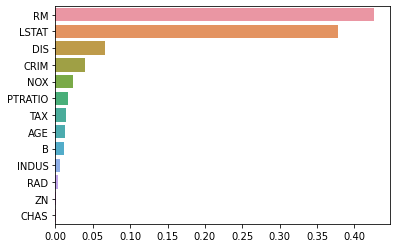

In [13]:
# 회귀 트리는 feature_importances_로 피처 중요도를 파악한다.
# 선형회귀의 회귀 계수 역할을 함.

import seaborn as sns

rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습함.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

<AxesSubplot:>

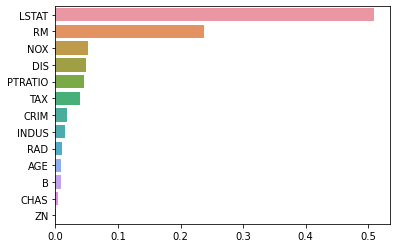

In [14]:
import seaborn as sns

xg_reg = XGBRegressor(num_round=1000, verbosity=0)

# 앞 예제에서 만들어진 X_data, y_target 데이터 셋을 적용하여 학습함.
xg_reg.fit(X_data, y_target)

feature_series = pd.Series(data=xg_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

In [15]:
impt_ftrs_rf = ["RM", "LSTAT", "DIS", "CRIM", "NOX"]
impt_ftrs_xg = ["LSTAT", "RM", "NOX", "DIS", "PTRATIO"]

X_data_rf = X_data[impt_ftrs_rf]
X_data_xg = X_data[impt_ftrs_xg]

In [16]:
# max_depth=4짜리 디시전 트리
dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
# n_estimators=1000짜리 랜덤 포레스트
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
# n_estimators=1000짜리 XGBoost
xg_reg = XGBRegressor(num_round=1000, verbosity=0)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
# rf에서 뽑힌 주요 피처 상위 5개 항목 평가
models = [dt_reg, rf_reg, xg_reg]
for model in models :
    get_model_cv_prediction(model, X_data_rf, y_target)

### DecisionTreeRegressor ### 
5 교차 검증의 평균 RMSE : 5.75
### RandomForestRegressor ### 
5 교차 검증의 평균 RMSE : 4.586
### XGBRegressor ### 
5 교차 검증의 평균 RMSE : 4.934


In [17]:
# xgb에서 뽑힌 주요 피처 상위 5개 항목 평가
models = [dt_reg, rf_reg, xg_reg]
for model in models :
    get_model_cv_prediction(model, X_data_xg, y_target)

# 예상과 달리 XGB에서 중요 피처의 RMSE 값이 떨어짐.

### DecisionTreeRegressor ### 
5 교차 검증의 평균 RMSE : 5.48
### RandomForestRegressor ### 
5 교차 검증의 평균 RMSE : 4.512
### XGBRegressor ### 
5 교차 검증의 평균 RMSE : 4.709


##### 회귀 트리의 오버 피팅 시각화

(100, 2)


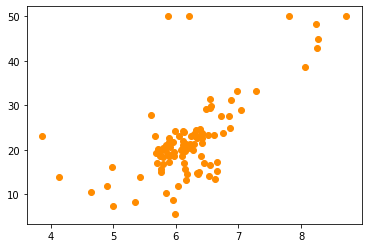

In [18]:
import matplotlib.pyplot as plt

bostonDF_sample = bostonDF[["RM", "PRICE"]]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성, DecisionTreeRegressor의 max_depth는 각각2, 7
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트 데이터 셋을 4.5 ~ 8.5까지 100개 데이터 셋 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출
X_feature = bostonDF_sample["RM"].values.reshape(-1, 1)
y_target = bostonDF_sample["PRICE"].values.reshape(-1, 1)

# 학습과 예측 수행.
lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

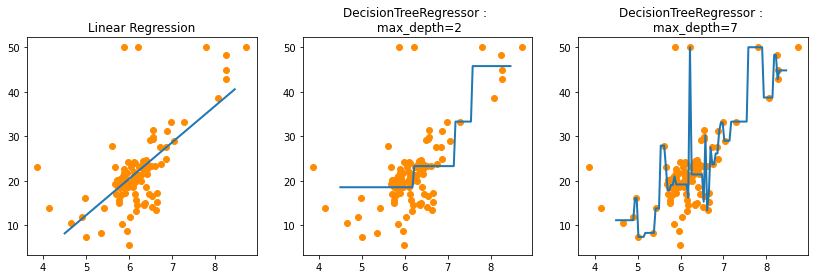

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

# x축 값을 4.5 ~ 8.5로 변환하여 입력했을 때, 선형 회귀와 결정 트리 회귀 예측 선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title("Linear Regression")
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax1.plot(X_test, pred_lr, label="linear", linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title("DecisionTreeRegressor : \n max_depth=2")
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax2.plot(X_test, pred_rf2, label="max_depth:2", linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title("DecisionTreeRegressor : \n max_depth=7")
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c="darkorange")
ax3.plot(X_test, pred_rf7, label="max_depth:7", linewidth=2)

# 선형 회귀는 직선으로 예측 회귀선을 표현
# 회귀 트리는 분할되는 데이터 지점에 따라 계단 형태로 회귀선 표현
# DTR의 max_depth=2 인 경우 어느정도 분류가 잘 됨
# max_depth=7인 경우 학습 데이터 세트의 outlier 데이터도 학습하면서
# 복잡한 계단 형태의 회귀선을 만들어 과적합 모델을 만듦.